# Longstaff-Schwartz: Least Squares Monte-Carlo (LSM) algorithm. 

In this case study, I will implement the algorithm mentioned on the "section 1 Numerical Example" from Longstaff-Schwartz paper, https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf, in Jupiter notebook.<br>
This Longstaff-Schwartz algorithm is also known as the Least Squares Monte-Carlo (LSM) algorithm.<br>

By emulating this paper's numerical example in Python programming, I hope I will learn interesting world of option for both European & American style from the perspective of programming.<br>
If possible I will scale up this case study to include more complex simulation and Machine Learning to enhance my understanding.


I will be using the same numerical example from the paper: <br>
Consider an American put option on a share of non-dividend-paying stock. The put option is exercisable at a strike price of $1.10 at times 1, 2, and 3, where time three is the final expiration
date of the option. The riskless rate is 6%. The current stock price is $1.00. The stock price could take on the following 8-paths. I will also use the explanation from the paper to describe the steps in the Python program.

Important part of the paper:<br>
To understand **the intuition** behind this approach, recall that at any exercise time, the holder of an American option optimally compares the payoff from immediate exercise with the expected payoff from continuation, and then exercises if the immediate payoff is higher. Thus the optimal exercise strategy is fundamentally determined by the **conditional expectation** of the payoff from continuing to keep the option alive. The **key insight** underlying our approach is that this conditional expectation can be estimated from the cross-sectional information in the sirnulation by using **least squares**. Specifically, we **regress** the ex post realized payoffs from continuation on functions of the values of the state variables. The fitted value from **this regression** provides a **direct estimate** of the conditional expectation function. By estimating the conditional expectation function for each exercise date, we obtain a complete specification of the optimal exercise strategy along each path. With this specification, American options can then be valued accurately by simulation. We refer to this technique as the least squares Monte Carlo (LSM) approach.

The *least squares method* is a form of mathematical regression analysis used to determine the line of best fit for a set of data, providing a visual demonstration of the relationship between the data points. https://www.investopedia.com/terms/l/least-squares-method.asp <br>

In [2]:
# import libraries
import numpy as np # type: ignore
import pandas as pd # type: ignore
from scipy.stats import norm # type: ignore
from sklearn.linear_model import LinearRegression # type: ignore 

# Paths

The paper assumes that the stock price follow the following 8 paths.

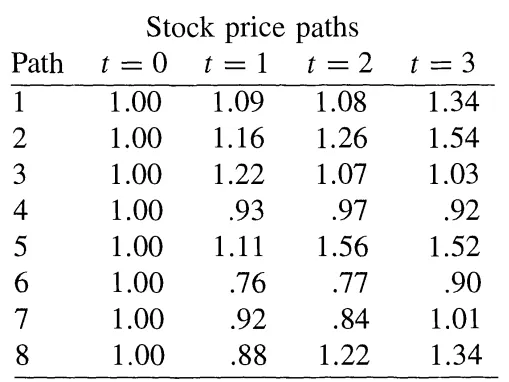

The steps below will produce the above table.

In [3]:
# from Longstaff-Schwartz paper
asset_price = 1
strike = 1.1 
r = 0.06
option_type = "Put"
t3 = [1.34,1.54,1.03,.92,1.52,.9,1.01,1.34] # exercise date
t2 = [1.08,1.26,1.07,.97,1.56,.77,.84,1.22] # exercisable date 2
t1 = [1.09,1.16,1.22,.93,1.11,.76,.92,.88]  # exercisable date 1
t0 = [1,1,1,1,1,1,1,1]                      # initial date
paths = np.array([t0,t1,t2,t3]) * asset_price

In [4]:
# store the paths into dataframe for better viewing
index = [1,2,3,4,5,6,7,8]
df_paths = pd.DataFrame(paths.T,columns=['t0','t1','t2','t3'],index = index)
df_paths.index.name = 'path'

In [5]:
df_paths.head(10)

,t0,t1,t2,t3
path,,,,
1,1.0,1.09,1.08,1.34
2,1.0,1.16,1.26,1.54
3,1.0,1.22,1.07,1.03
4,1.0,0.93,0.97,0.92
5,1.0,1.11,1.56,1.52
6,1.0,0.76,0.77,0.90
7,1.0,0.92,0.84,1.01
8,1.0,0.88,1.22,1.34


Now that we have the potential paths, we need to calculate the cash flows that would be generated if the option was exercised at any point in time.<br>
Since it is a put option, if the price is above $1.10, exercising the contract is worthless (or 0).

# Cash Flows

As mentioned their paper, the LS objective is to solve for the stopping rule that maximizes the value of the option at each point along each path. Since the algorithm is recursive, however, we first need to compute a number of intermediate matrices. Conditional on not exercising the option before the final expiration date at time 3, the cash flows realized by the optionholder from following the optimal strategy at time 3 are given below.

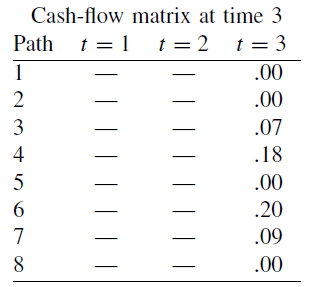

In [6]:
# calculate cash flows and fill in into the dataframe
def calculate_cashflows(option_type):
    if option_type == "Call":
        df_CF = np.maximum(df_paths - strike, 0) 
    else:
        df_CF = np.maximum(strike - df_paths, 0) 

    return df_CF

In [7]:
df_CF = calculate_cashflows(option_type) # type: ignore
df_CF.head(10)

,t0,t1,t2,t3
path,,,,
1,0.1,0.01,0.02,0.00
2,0.1,0.00,0.00,0.00
3,0.1,0.00,0.03,0.07
4,0.1,0.17,0.13,0.18
5,0.1,0.00,0.00,0.00
6,0.1,0.34,0.33,0.20
7,0.1,0.18,0.26,0.09
8,0.1,0.22,0.00,0.00


The t3 cash-flows same at the table in the paper.

# t3 : What if the put exercised at t3 (t3 = exercise date)?
Exercising at t3, produce the European put price.

To obtain the European option value, I will just discount back the cash-flows t3 to time zero.

In [8]:
# European 
euro_put = (df_CF['t3']*np.exp(-3*r)).mean()
euro_put

0.05638073927026089

This is the European option value as mentioned in the paper.

# t2 : What if the put exercised at t2?

Longstaff-Schwartz’s algorithm creates a stopping rule to maximize the value of the option. It considers each time period and whether its best to exercise the option early, or looking forward, continue holding the option for the next period. They do this by comparing the payoff at t=2 to the conditional expectation of holding the option, which gives the Least Squares portion of the algorithm’s name. X represents the stock price of in-the-money options at t = 2, and Y is the discounted cash flow at t=3. <br>
or if I used the explanation from **the paper**:<br>
If the put is in the money at time 2, the option holder must then decide whether to exercise the option immediately or continue the option's life until the final expiration date at time 3. From the stock-price matrix, there are only five paths for which the option is in the money at time 2. Let X denote the stock prices at time 2 for these five paths and Y denote the corresponding
discounted cash flows received at time 3 if the put is not exercised at time 2. We use only in-the-money paths since it allows us to better estimate the conditional expectation function in the region where exercise is relevant and significantly improves the efficiency of the algorithm. The vectors X and Y are given by the nondashed entries below.

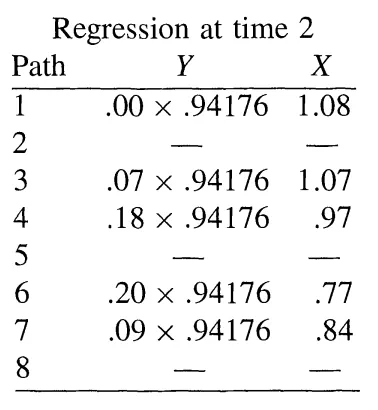

In the steps below, I will produce this table. The 0.9417645336 = np.exp(-r) is used to discount the cash flow at t=3.

In [9]:
# put options in_the_money if strike > underlying price
in_the_money =df_paths['t2'] < strike 

# using Linear Regression to predict the expected value if holding the option
X = (df_paths['t2'].loc[in_the_money])
X2 = X*X
Xs = np.column_stack([X,X2])
Y = (df_CF['t3'].loc[in_the_money])  * np.exp(-r)
model_sklearn = LinearRegression()
model = model_sklearn.fit(Xs, Y)
conditional_exp = model.predict(Xs) # conditional expectation of holding the option
continuations = np.zeros_like(df_paths['t2'])
continuations[in_the_money] = conditional_exp
continuations = np.round(continuations,4)

In [10]:
# combine/concate Y, X, X^2 for regression table
df_regre_t2 = pd.concat([Y,X,X2], axis=1)
print("Regression at time 2")
df_regre_t2.columns = ['Y','X','X^2']
df_regre_t2

Regression at time 2


,Y,X,X^2
path,,,
1,0.000000,1.08,1.1664
3,0.065924,1.07,1.1449
4,0.169518,0.97,0.9409
6,0.188353,0.77,0.5929
7,0.084759,0.84,0.7056


Path #2, #5 and #8 gone as they are not in_the_money.

With this conditional expectation function, we now compare the value of immediate exercise at time 2, given in the first column below, with the value from continuation (to time 3). given in the second column below.

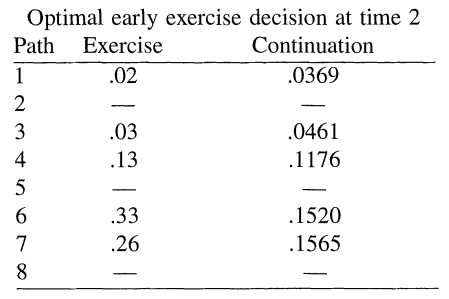

The steps below, I will produce the table above.

In [11]:
# if exercise at t2, the option values is the cash flows at t2
exercise = df_CF['t2'].to_numpy()
# This values are from the LS paper. This will be used to compare the calculated continuations
paper_continuations = [0.0369, 0.0000, 0.0461, 0.1176, 0.0000, 0.1520, 0.1565, 0.0000]
compare_continuations = np.array([exercise, continuations, paper_continuations]) # type: ignore

# now let's compare the calculated values vs LS paper values
df_compare = pd.DataFrame(compare_continuations.T, columns=['exercise','calc','paper'],index = index)
df_compare.index.name = 'path'
print("Optimal early exercise decision at time 2")
df_compare.head(10)

Optimal early exercise decision at time 2


,exercise,calc,paper
path,,,
1,0.02,0.0367,0.0369
2,0.00,0.0000,0.0000
3,0.03,0.0459,0.0461
4,0.13,0.1175,0.1176
5,0.00,0.0000,0.0000
6,0.33,0.1520,0.1520
7,0.26,0.1564,0.1565
8,0.00,0.0000,0.0000


calc = Conditional expectation of holding the put calculated using LinearRegression <br>
paper = Values in the paper <br>
The calculated values are very much similar to the values in the paper.

The comparison between exercice and calc on the table above implies that it is optimal to exercise the otion at time 2 for the fourth, sixth, and seventh paths. This leads to the following matrix, which shows the cash flows received by the option holder conditional on not exercising prior to time 2.

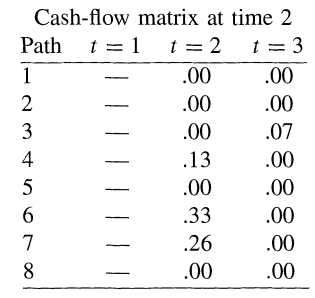

The steps below, I will produce the table above.

In [12]:
df_CF['t2'] = np.where(df_compare['exercise'] > df_compare['calc'], df_compare['exercise'], 0 )
df_CF['t3'] = np.where(df_compare['calc'] > df_compare['exercise'], df_CF['t3'], 0 )
df_t2optimal = pd.concat([df_CF['t2'],df_CF['t3']], axis=1)
print("Cash-flow matrix at time t2")
df_t2optimal.head(10)

Cash-flow matrix at time t2


,t2,t3
path,,
1,0.00,0.00
2,0.00,0.00
3,0.00,0.07
4,0.13,0.00
5,0.00,0.00
6,0.33,0.00
7,0.26,0.00
8,0.00,0.00


When the option is exercised at time 2, the cash flow in the final column (t3) becomes zero, because once the option is exercised there are no further cash flows as it can only be exercised once.

# t1 : What if the put is exercise at t1?

From the stock price matrix, there are again five paths where the option is in the money at time 1. For these paths, let X represents the stock price of in-the-money options at t = 1, and Y is the discounted cash flow at t=2. <br>
Since the option can only be exercised once, future cash flows occur at either time 2 or time 3, but not both. Cash flows received at time 2 are discounted back one period to time 1, and any cash flows received at time 3 are discounted back two periods to time 1. Similarly X represents the stock prices at time 1 for the paths where the option is in the money. The vectors X and Y are given by the nondashed elements in the following matrix.

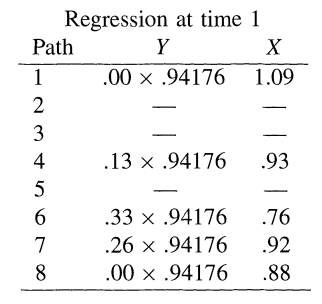

The steps below, I will produce the table above.<br>

In [13]:
# put options in_the_money if price < strike
in_the_money =df_paths['t1'] < strike 

# Run Regression
X = (df_paths['t1'].loc[in_the_money])
X2 = X*X
Xs = np.column_stack([X,X2])
Y = (df_CF['t2'].loc[in_the_money])  * np.exp(-r)
model_sklearn = LinearRegression()
model = model_sklearn.fit(Xs, Y)
conditional_exp = model.predict(Xs) # conditional expectation of holding the option
continuations = np.zeros_like(df_paths['t1'])
continuations[in_the_money] = conditional_exp
continuations = np.round(continuations,4)

In [14]:
# combine/concate Y, X, X^2 for regression table
df_regre_t1 = pd.concat([Y,X,X2], axis=1)
print("Regression at time 1")
df_regre_t1.columns = ['Y','X','X^2']
df_regre_t1

Regression at time 1


,Y,X,X^2
path,,,
1,0.000000,1.09,1.1881
4,0.122429,0.93,0.8649
6,0.310782,0.76,0.5776
7,0.244859,0.92,0.8464
8,0.000000,0.88,0.7744


Path #2, #3 and #5 gone as they are not in_the_money.

With this conditional expectation function, we now compare the value of immediate exercise at time 1, given in the first column below, with the value from continuation (to time 2), given in the second column below.

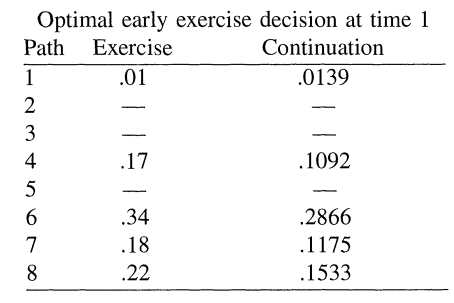

The steps below, I will produce the table above.

In [15]:
exercise = df_CF['t1'].to_numpy()
# This values are from the LS paper. This will be used to compare the calculated continuations
paper_continuations = [0.0139, 0.0000, 0.0000, 0.1092, 0.0000, 0.2866, 0.1175, 0.1533]
compare_continuations = np.array([exercise, continuations, paper_continuations])

# now let's compare the calculated values vs paper values
df_compare = pd.DataFrame(compare_continuations.T, columns=['exercise','calc','paper'],index = index)
df_compare.index.name = 'path'
print("Optimal early exercise decision at time 2")
df_compare.head(10)

Optimal early exercise decision at time 2


,exercise,calc,paper
path,,,
1,0.01,0.0135,0.0139
2,0.00,0.0000,0.0000
3,0.00,0.0000,0.0000
4,0.17,0.1087,0.1092
5,0.00,0.0000,0.0000
6,0.34,0.2861,0.2866
7,0.18,0.1170,0.1175
8,0.22,0.1528,0.1533


Comparing the two columns shows that exercise at time 1 is optimal for the fourth, sixth,seventh, and eighth paths. 

In [16]:
# updating the cash flow matrix
df_CF['t1'] = np.where(df_compare['exercise'] > df_compare['calc'], df_compare['exercise'], 0 )
df_CF['t2'] = np.where(df_compare['calc'] > df_compare['exercise'], df_CF['t2'], 0 )

# Stopping Rule

Having identified the exercise strategy at times 1, 2, and 3, the stopping rule can now be represented by the following matrix, where the ones denote exercise dates at which the option is exercised.
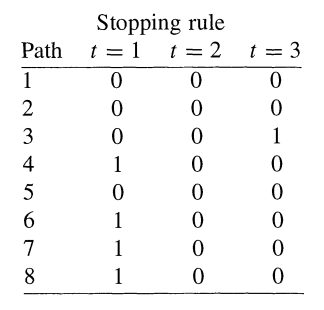

The steps below, I will produce the table above.

In [17]:
# creating stoping rule matrix for displaying
df_stopping_rule = pd.DataFrame(index=index)
df_stopping_rule['t1'] = np.where(df_CF['t1'] > 0, 1, 0 )
df_stopping_rule['t2'] = np.where(df_CF['t2'] > 0, 1, 0 )
df_stopping_rule['t3'] = np.where(df_CF['t3'] > 0, 1, 0 )
df_stopping_rule.index.name = 'path'
print("Stopping Rule")
df_stopping_rule


Stopping Rule


,t1,t2,t3
path,,,
1,0,0,0
2,0,0,0
3,0,0,1
4,1,0,0
5,0,0,0
6,1,0,0
7,1,0,0
8,1,0,0


With this specification of the stopping rule, it is now straight forward to determine the cash flows realized by following this stopping rule. This is done by simply exercising the option at the exercise dates where there is a one in the above matrix. This leads to the following option cash flow matrix.

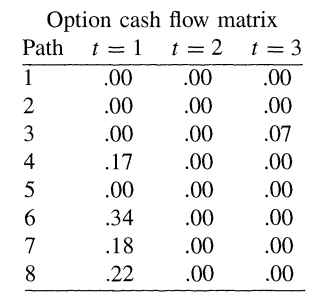

In [18]:
print("Cash-flow matrix")
df_CF[['t1','t2','t3']].head(10)

Cash-flow matrix


,t1,t2,t3
path,,,
1,0.00,0.0,0.00
2,0.00,0.0,0.00
3,0.00,0.0,0.07
4,0.17,0.0,0.00
5,0.00,0.0,0.00
6,0.34,0.0,0.00
7,0.18,0.0,0.00
8,0.22,0.0,0.00


Having identified the cash flows generated by the American put at each date along each path, the option can now be valued by discounting each cash flow in the option cash flow matrix back to time zero, and averaging over all paths. Applying this procedure results in a value of **0.1144** for the American put. This is roughly twice the value of **0.0564** for the European put obtained by discounting back the cash flows at time 3 from the first cash flow matrix.

In [19]:
# American styple: use the stopping rule & cash-flows to calculate the option value by discounting to time 0
dcfs = []
df_CF_calc = df_CF[['t1','t2','t3']].copy(deep=True)
for idx, row in df_CF_calc.iterrows(): 
    dcf = 0
    for j, col in enumerate(row):
        dcf = dcf + col*np.exp(-(j+1)*r)
    dcfs.append(dcf)

df_CF_calc['t0'] = dcfs
ame_put = df_CF_calc['t0'].mean()
ame_put

0.11443433004505696

This program results both for European & American style is the same with results in the paper. <br>

https://medium.datadriveninvestor.com/a-complete-step-by-step-guide-for-pricing-american-option-712c84aa254e <br>
https://medium.com/@ptlabadie/pricing-american-options-in-python-8e357221d2a9 <br>
https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/2.3%20American%20Options.ipynb <br>


https://github.com/greyhatguy007/Machine-Learning-Specialization-Coursera